# **Marketing Campaigns：Funnel Analysis and A/B testing**
---
A control and a new marketing campaign were lanuched. Data contains the corresponding customer behaviours in one month of the testing period. The new and control campaigns were randomly assigned. 
## **Aims**
- To explore whether the new campaign significantly improve user engagements and conversions in one month.
## **Dataset description**
`control_group.csv` and `test_group.csv` contains the following features: 
| Column Name          | Description                                                   |
|----------------------|---------------------------------------------------------------|
| `Campaign Name`        | The name of the campaign                                      |
| `Date`                 | Date of the record                                            |
| `Spend`                | Amount spent on the campaign in dollars                       |
| `# of Impressions`     | Number of impressions the ad delivered through the campaign   |
| `Reach`                | Number of unique users who saw the ad                         |
| `# of Website Clicks`  | Number of website clicks generated by the ads                 |
| `# of Searches`        | Number of users who performed searches on the website         |
| `# of View Content`    | Number of users who viewed content or products on the website |
| `# of Add to Cart`     | Number of users who added products to the cart                |
| `# of Purchase`        | Number of purchases made                                     |



## **Specific objectives**
- To determine whether the new campaign significantly improve conversions compared to the old campaign.
- To conduct funnel analysis to understand the flow of customers behaviour/engagement and to determine if customer behaviour/engagement at each step significantly differ by campaigns. 
- To explore whether there is day-of-week effect
- To make final decisions on which campaign to carry out. 

## **Key metrics**
### **Metrics for funnel analysis and a/b testing**: 
- **CTR**: 
  - Click through rate = number of clicks / number of impressions
- **Search rate**: 
  - Number of searches / number of clicks 
- **View rate**: 
  - Number of views / number of searches
- **ATC rate**: 
  - Add to cart rate = number of add to carts / number of views
- **Purchase rate**: 
  - Number of purchases / number of add to carts
- **Overall conversion rate**: 
  - Number of purchases / number of impressions

## **Analysis Plan** 
- **Data Cleaning and Preprocessing**
  - Missing value check 
  - Data aggregation to daily level 
- **Experiment Integrity Checks**
  - Sample Ratio Mismatch (SRM) check  
  - Daily impression balance and test-share check 
  - Assessment of delivery stability over the testing period (line plot)
  - Implications for causal interpretability 
- **Descriptive and Exploratory Analysis** 
  - Visualization of daily metrics over the testing period 
  - Funnel analysis 
    - Metric construction (funnel step rates, overall CVR, etc.)
    - Absolute funnel (impression volume context) and visualization
    - Conditional funnel rates (normalized funnel) and visualization 
- **Hypothesis Testing**
  - Defining hypotheses for each funnel metric
  - Choosing statistical tests based on data structure 
     - Chi square test of funnel rates 
     - Multiple testing correction (FDR)
  - Estimation of effect size (relative lift)
- **Results interpretation**
  - Summary of key findings across funnel stages 
  - Discussion of potential drivers for the results 
- **Recommendations**
  - Experiment design improvements 
  - Randomization and stratification strategies 
  - Rerun or follow-up experiment proposal 
- **Executive Summary** 
  - Key results
  - Validity caveats
  - Recommendationed actions to stakeholders 

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
!pip install pingouin
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Cleaning and Preprocessing 

In [ ]:
df_control=pd.read_csv('C:/Users/08042/Desktop/projects/ab testing/ab2/control_group.csv', sep=';')
df_test=pd.read_csv('C:/Users/08042/Desktop/projects/ab testing/ab2/test_group.csv', sep=';')
df_control['group'] = 'control'
df_test['group'] = 'test'
df = pd.concat([df_control, df_test], ignore_index=True)


In [52]:
# check na 
df.isna().sum()
df.dropna(inplace=True)

In [88]:
# create daily metrics
df['ctr'] = df['# of Website Clicks'] / df['# of Impressions']
df['search_rate'] = df['# of Searches'] / df['# of Website Clicks']
df['view_rate'] = df['# of View Content'] / df['# of Searches']
df['add_to_cart_rate'] = df['# of Add to Cart'] / df['# of View Content']
df['purchase_rate'] = df['# of Purchase'] / df['# of Add to Cart']      
df['conversion_rate'] = df['# of Purchase'] / df['# of Impressions']
df['Date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,group,ctr,search_rate,view_rate,add_to_cart_rate,purchase_rate,conversion_rate
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,control,0.084835,0.326397,0.942795,0.842520,0.339747,0.007473
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,control,0.067003,0.250678,0.905558,0.662140,0.419196,0.004222
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,control,0.049411,0.266902,0.891767,0.732085,0.328042,0.002824
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,control,0.042057,0.339967,0.942418,1.204684,0.287405,0.004665
4,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign Name        60 non-null     object        
 1   Date                 60 non-null     datetime64[ns]
 2   Spend [USD]          60 non-null     int64         
 3   # of Impressions     59 non-null     float64       
 4   Reach                59 non-null     float64       
 5   # of Website Clicks  59 non-null     float64       
 6   # of Searches        59 non-null     float64       
 7   # of View Content    59 non-null     float64       
 8   # of Add to Cart     59 non-null     float64       
 9   # of Purchase        59 non-null     float64       
 10  group                60 non-null     object        
 11  ctr                  59 non-null     float64       
 12  search_rate          59 non-null     float64       
 13  view_rate            59 non-null     

## 2. Experiment Integrity Checks 

### 2.1 SRM check

In [110]:
# sample ratio mismatch check 
from scipy.stats import chisquare
observed = [df_control['# of Impressions'].sum(),
            df_test['# of Impressions'].sum()]
expected = [0.5 * sum(observed),
            0.5 * sum(observed)]
statistic, pvalue = chisquare(observed, f_exp=expected)

if pvalue < 0.01:
    print('SRM may be present')
else: 
    print('SRM likely not present')

SRM may be present


### 2.2 Visualization of daily test campaign impression share

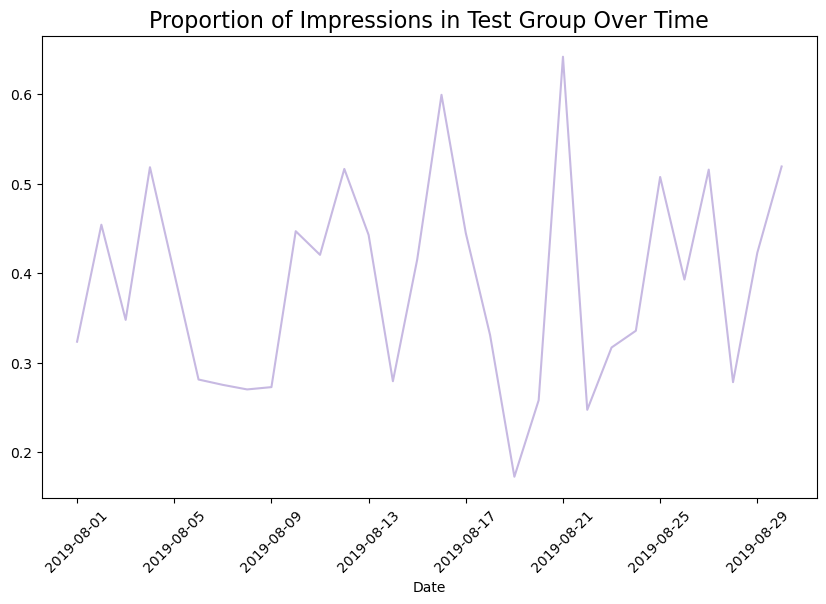

In [111]:
ratio = df_test['# of Impressions'].values / (
    df_control['# of Impressions'].values + df_test['# of Impressions'].values
)

df_control['Date'] = pd.to_datetime(df_control['Date'],format='%d.%m.%Y')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_control, x='Date', y=ratio, color='#c7b9e2')
plt.title('Proportion of Impressions in Test Group Over Time', fontsize=16)
plt.xticks(rotation=45)
plt.show()

- p-value of the chi-square test <.001, meaning there was **a significant sample ratio mistach between control and test campaign**, which likely due to incorrect bucketing or faulty randomization. The **daily test impression share** also showed that the test campaign was **not following a stable delivery pattern** and **made up less than 50% of the total daily delivery amount** most of the time throughout the testing period. Therefore, the funnel differences should be interpreted as **associative** rather than causal and may reflect audience compositon or platform optimazation. 

- Given the unproportional daily delivery of test and control compaigns, the results of the A/B test should be interpreted with caution, and a redesign of the experiment should be considered.


## 3. Descriptive and Exploratory Analysis

### 3.1 Visualization of daily metrics 

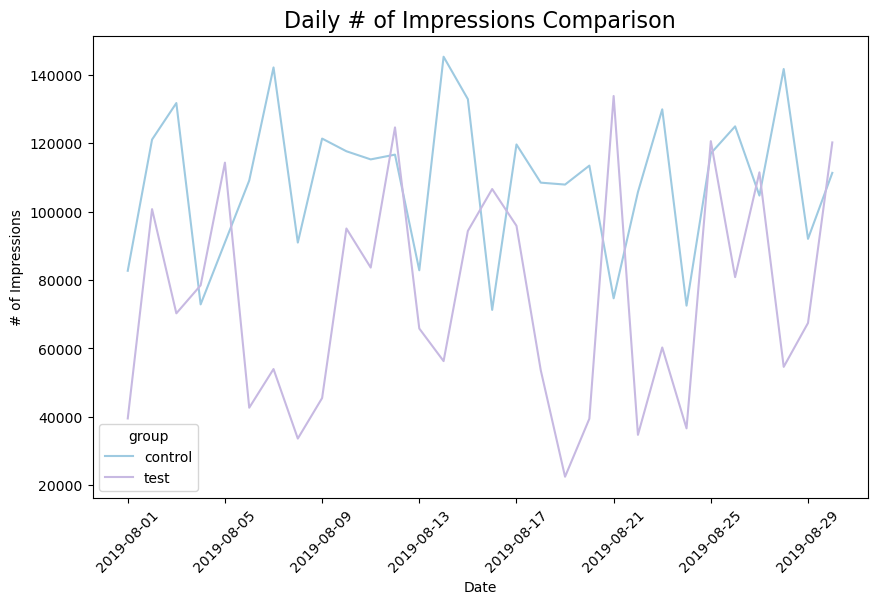

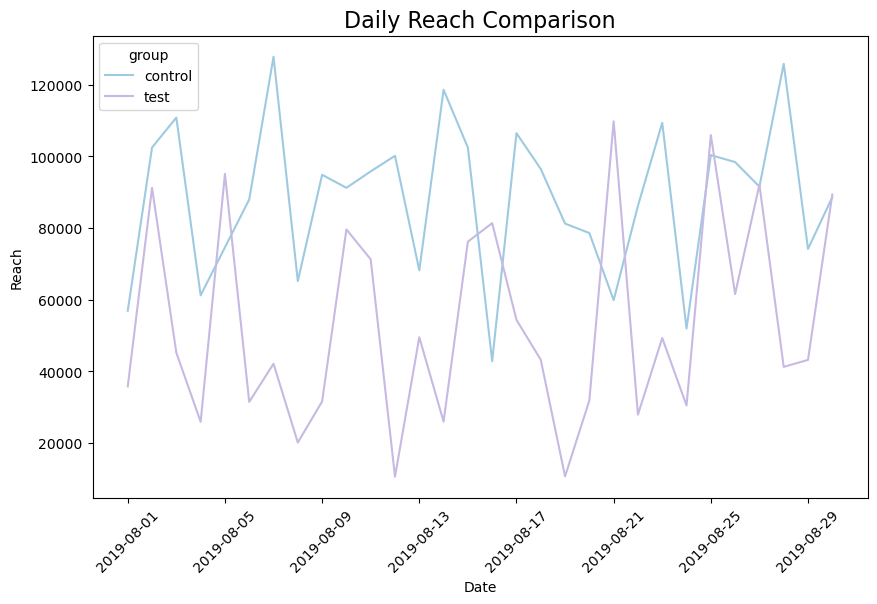

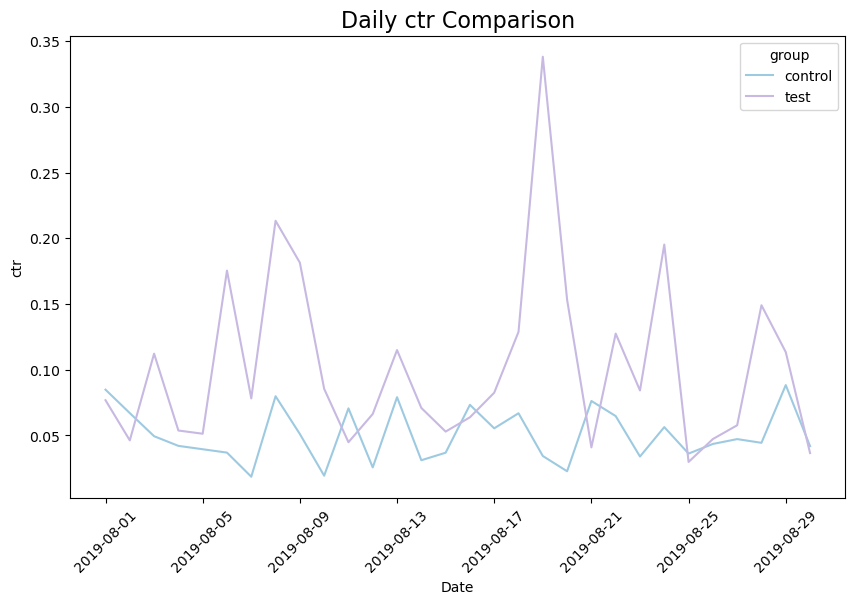

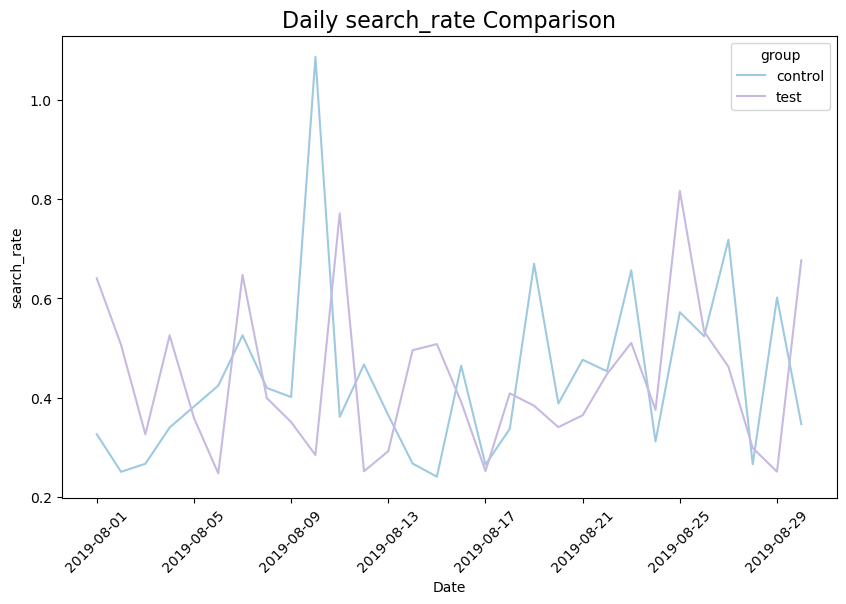

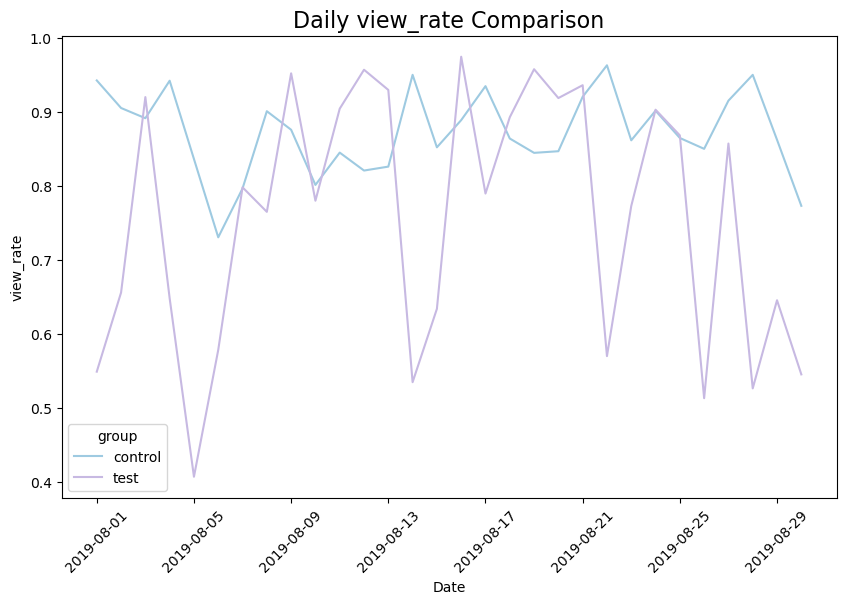

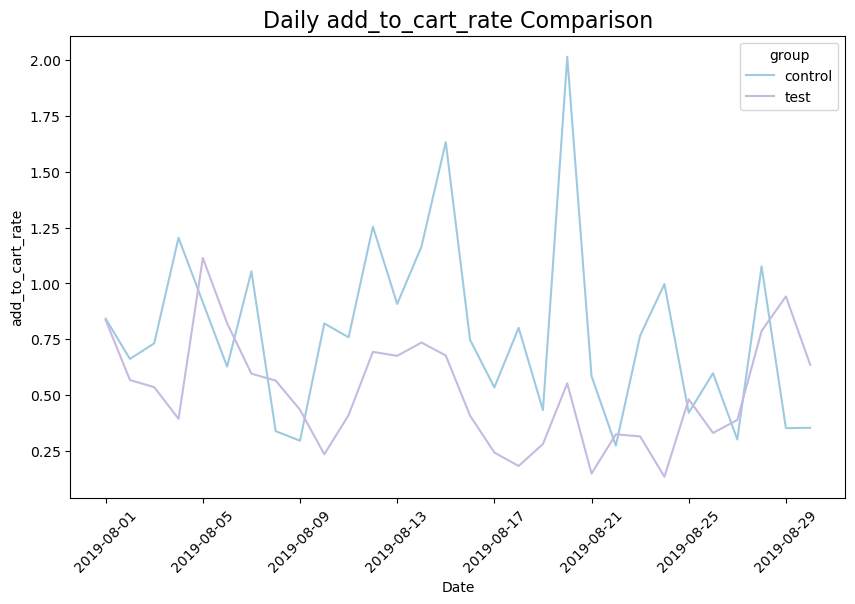

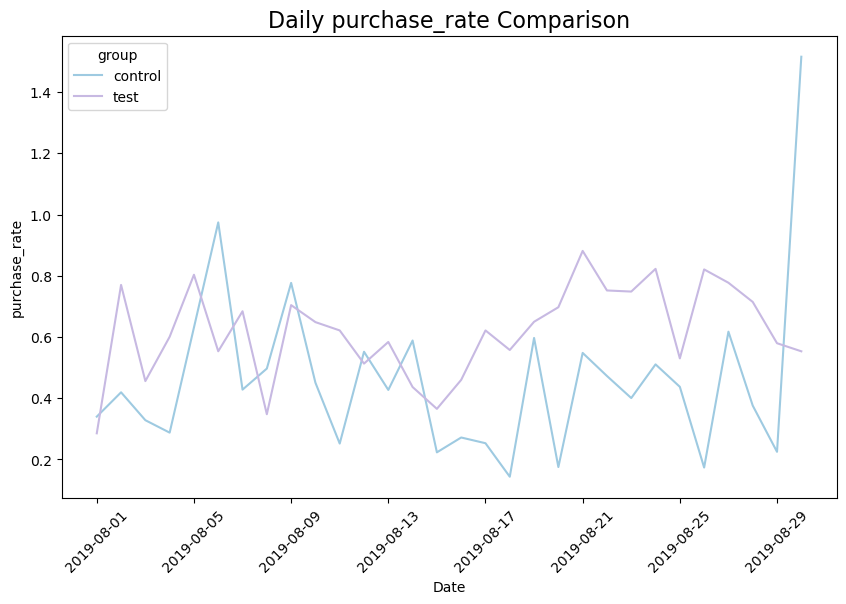

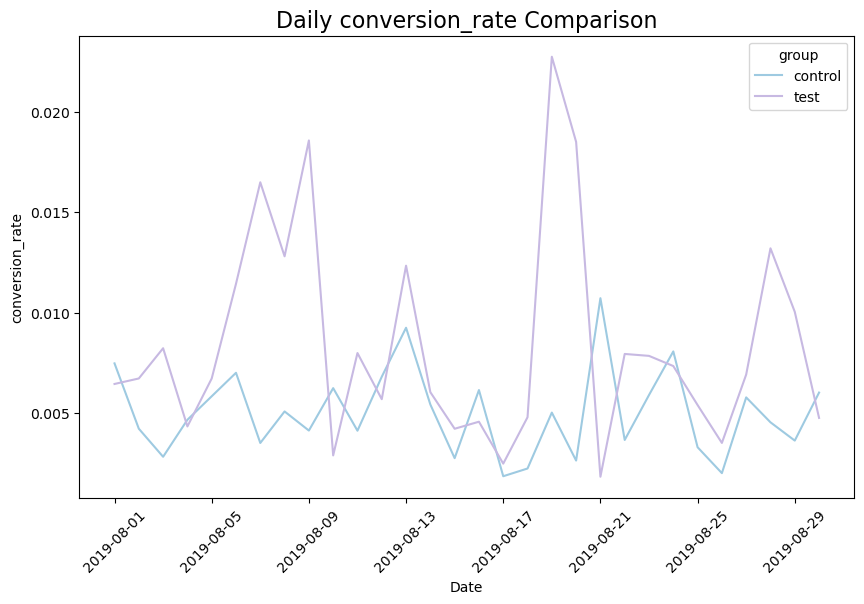

In [112]:
# plot daily metrics

metrics =['# of Impressions', 'Reach','ctr', 'search_rate', 'view_rate', 'add_to_cart_rate', 'purchase_rate', 'conversion_rate']
palette = {
    'control': '#9ecae1',  
    'test': '#c7b9e2'       
}
for metric in metrics: 
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Date', y=metric, hue='group', palette=palette)
    plt.title(f'Daily {metric} Comparison',fontsize=16)
    plt.xticks(rotation=45)
    plt.show()


### 3.2 Funnel analysis 

#### 3.2.1 funnel rates with absolute value of impressions

In [106]:
def funnel_rates(df): 
    totals = df.sum(numeric_only=True)
    return pd.Series({
        'Impressions': totals['# of Impressions'],
        'CTR': totals['# of Website Clicks'] / totals['# of Impressions'],
        'Search rate': totals['# of Searches'] / totals['# of Website Clicks'],
        'View rate': totals['# of View Content'] / totals['# of Searches'],
        'ATC rate': totals['# of Add to Cart'] / totals['# of Searches'],
        'Purchase rate': totals['# of Purchase'] / totals['# of Add to Cart'],
        'Overall CVR': totals['# of Purchase'] / totals['# of Impressions']
    })

control_ab_rate = round(funnel_rates(df_control), 4)
test_ab_rate = round(funnel_rates(df_test), 4)

funnel_ab_rate = pd.concat([control_ab_rate.rename('control'), 
                            test_ab_rate.rename('test')], axis=1)
funnel_ab_rate

,control,test
Impressions,3.177233e+06,2.237544e+06
CTR,4.860000e-02,8.090000e-02
Search rate,4.175000e-01,4.010000e-01
View rate,8.751000e-01,7.681000e-01
ATC rate,5.852000e-01,3.644000e-01
Purchase rate,4.021000e-01,5.913000e-01
Overall CVR,4.800000e-03,7.000000e-03


### 3.2.2 Conditional funnel rates with normalizied impressions 

In [ ]:
def compute_funnel_rates(df):
    t = df.sum(numeric_only=True)
    return pd.Series({
        'Impressions': 1.0,
        'Clicks': t['# of Website Clicks'] / t['# of Impressions'],
        'Searches': t['# of Searches'] / t['# of Website Clicks'],
        'View Content': t['# of View Content'] / t['# of Searches'],
        'Add to Cart': t['# of Add to Cart'] / t['# of View Content'],
        'Purchase': t['# of Purchase'] / t['# of Add to Cart'],
    })

control_rates = compute_funnel_rates(df_control)
test_rates = compute_funnel_rates(df_test)

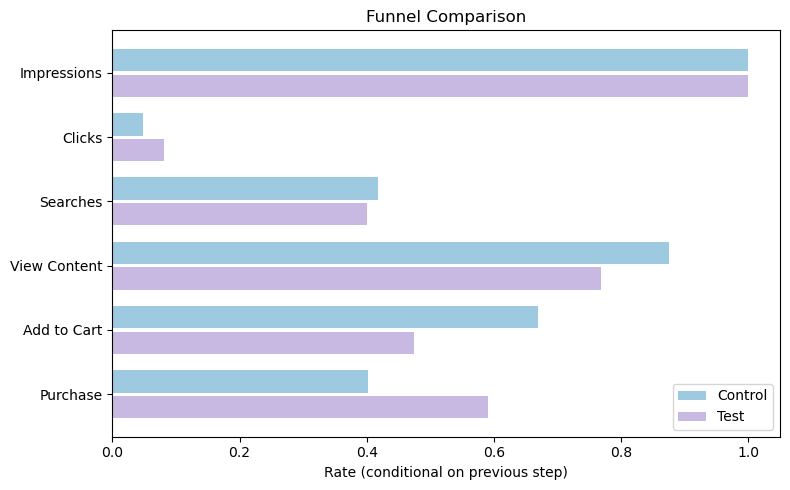

In [64]:
def plot_funnel(control_rates, test_rates, title='Funnel Comparison'):
    steps = control_rates.index.tolist()
    y = np.arange(len(steps))

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.barh(y - 0.2, control_rates.values, height=0.35, label='Control', color='#9ecae1')
    ax.barh(y + 0.2, test_rates.values, height=0.35, label='Test', color='#c7b9e2')

    ax.set_yticks(y)
    ax.set_yticklabels(steps)
    ax.invert_yaxis()  # top = first step
    ax.set_xlabel('Rate (conditional on previous step)')
    ax.set_title(title)
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_funnel(control_rates, test_rates)


## 4. Hypothesis Testing 

### 4.1 Defining hypotheses 
- _H0_: There is no difference in each funnel metric between control and test groups.
- _H1_: There is a significant difference in each funnel metric between control and test groups.

### 4.2 Choosing the statistical test
- The funnel metrics are all proportions invovling multiple categorical stages
   - -> two proportions z-test or chi-square test 
   - -> chi-square test
     - Because chi-square naturally tests whether progression through those stages is independent of variant assignment.
- To account for multiple comparisons across funnel stages
   - p-values are adjusted using a false discovery rate (FDR)
     - fdr_adjusted p-value < alpha: reject _H0_
     - fdr_adjusted p-value > alpha: fail to reject _H0_
- The chi-square test does not require assumptions of normality of the underlying data
  - However, it assumes:
    - independent exposure units (impressions)
    - sufficiently large expected cell counts
    - These conditions are assessed via sample size and expected-frequency diagnostics

### 4.3 Chi-square test for funnel metrics 

In [67]:
def run_funnel_tests(
    control_df: pd.DataFrame,
    test_df: pd.DataFrame,
    funnel_steps,
    alpha: float = 0.05,
    correction: str = 'fdr_bh',
):
    '''
    funnel_steps: list of tuples (metric_name, numerator_col, denominator_col)
      Example:
        ('CTR', '# of Website Clicks', '# of Impressions')
        ('Search rate', '# of Searches', '# of Website Clicks')
        ...
    Returns: results DataFrame with rates, lift, p-values, corrected p-values.
    '''
    ctrl = control_df.sum(numeric_only=True)
    tst = test_df.sum(numeric_only=True)

    rows = []
    for metric, num_col, den_col in funnel_steps:
        # Totals
        ctrl_den = float(ctrl.get(den_col, np.nan))
        ctrl_num = float(ctrl.get(num_col, np.nan))
        tst_den  = float(tst.get(den_col, np.nan))
        tst_num  = float(tst.get(num_col, np.nan))

        # Rates + lift
        p_ctrl = ctrl_num / ctrl_den
        p_tst  = tst_num  / tst_den
        lift = np.nan if p_ctrl == 0 else (p_tst - p_ctrl) / p_ctrl

        # 2x2 table: [success, failure] for each group
        table = np.array([
            [ctrl_num, ctrl_den - ctrl_num],
            [tst_num,  tst_den  - tst_num]
        ], dtype=float)

        # Chi-square test of independence (no Yates correction by default)
        chi2, pval, dof, expected = chi2_contingency(table, correction=False)

        rows.append({
            'metric': metric,
            'num_col': num_col,
            'den_col': den_col,
            'control_num': ctrl_num, 'control_den': ctrl_den,
            'test_num': tst_num, 'test_den': tst_den,
            'control_rate': p_ctrl,
            'test_rate': p_tst,
            'lift': lift,
            'pval': pval,
            'min_expected': expected.min(),
            'note': ''
        })

    res = pd.DataFrame(rows)

    # Multiple testing correction (only on valid p-values)
    valid = res['pval'].notna()
    if valid.any():
        reject, pvals_corr = pg.multicomp(res.loc[valid, 'pval'].values, method=correction, alpha=alpha)
        res.loc[valid, 'pval_adj'] = pvals_corr
        res.loc[valid, 'reject_adj'] = reject
    else:
        res['pval_adj'] = np.nan
        res['reject_adj'] = False

    # Helpful formatting columns for lift %
    res['lift_pct'] = res['lift'] * 100
    return res


funnel_steps = [
    ('CTR',              '# of Website Clicks', '# of Impressions'),
    ('Search rate',      '# of Searches',       '# of Website Clicks'),
    ('View content rate','# of View Content',   '# of Searches'),
    ('Add-to-cart rate', '# of Add to Cart',    '# of View Content'),
    ('Purchase rate',    '# of Purchase',       '# of Add to Cart'),
    ('Overall CVR',      '# of Purchase',       '# of Impressions'),
]

results = run_funnel_tests(df_control, df_test, funnel_steps, correction='fdr_bh')
results.sort_values('pval_adj', na_position='last')

,metric,num_col,den_col,control_num,control_den,test_num,test_den,control_rate,test_rate,lift,pval,min_expected,note,pval_adj,reject_adj,lift_pct
0,CTR,# of Website Clicks,# of Impressions,154303.0,3177233.0,180970.0,2237544.0,0.048565,0.080879,0.665366,0.000000e+00,138544.595560,,0.000000e+00,True,66.536601
2,View content rate,# of View Content,# of Searches,56370.0,64418.0,55740.0,72569.0,0.875066,0.768097,-0.122242,0.000000e+00,11698.384416,,0.000000e+00,True,-12.224153
3,Add-to-cart rate,# of Add to Cart,# of View Content,37700.0,56370.0,26446.0,55740.0,0.668795,0.474453,-0.290586,0.000000e+00,23847.233610,,0.000000e+00,True,-29.058607
4,Purchase rate,# of Purchase,# of Add to Cart,15161.0,37700.0,15637.0,26446.0,0.402149,0.591280,0.470303,0.000000e+00,12697.345244,,0.000000e+00,True,47.030334
5,Overall CVR,# of Purchase,# of Impressions,15161.0,3177233.0,15637.0,2237544.0,0.004772,0.006988,0.464546,4.593306e-250,12726.633084,,5.511968e-250,True,46.454617
1,Search rate,# of Searches,# of Website Clicks,64418.0,154303.0,72569.0,180970.0,0.417477,0.401000,-0.039468,3.905980e-22,63045.652531,,3.905980e-22,True,-3.946834


In [68]:
funel_cols = ['metric', 'control_rate', 'test_rate', 'lift','lift_pct', 'pval', 'pval_adj']
funnel_results = results[funel_cols]
funnel_results 

,metric,control_rate,test_rate,lift,lift_pct,pval,pval_adj
0,CTR,0.048565,0.080879,0.665366,66.536601,0.000000e+00,0.000000e+00
1,Search rate,0.417477,0.401000,-0.039468,-3.946834,3.905980e-22,3.905980e-22
2,View content rate,0.875066,0.768097,-0.122242,-12.224153,0.000000e+00,0.000000e+00
3,Add-to-cart rate,0.668795,0.474453,-0.290586,-29.058607,0.000000e+00,0.000000e+00
4,Purchase rate,0.402149,0.591280,0.470303,47.030334,0.000000e+00,0.000000e+00
5,Overall CVR,0.004772,0.006988,0.464546,46.454617,4.593306e-250,5.511968e-250


### 4.4 Estimate of effect size (relative lift)

C:\Users\08042\AppData\Local\Temp\ipykernel_7652\2486525896.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(max(control_rates[i], test_rates[i]) + 0.01,


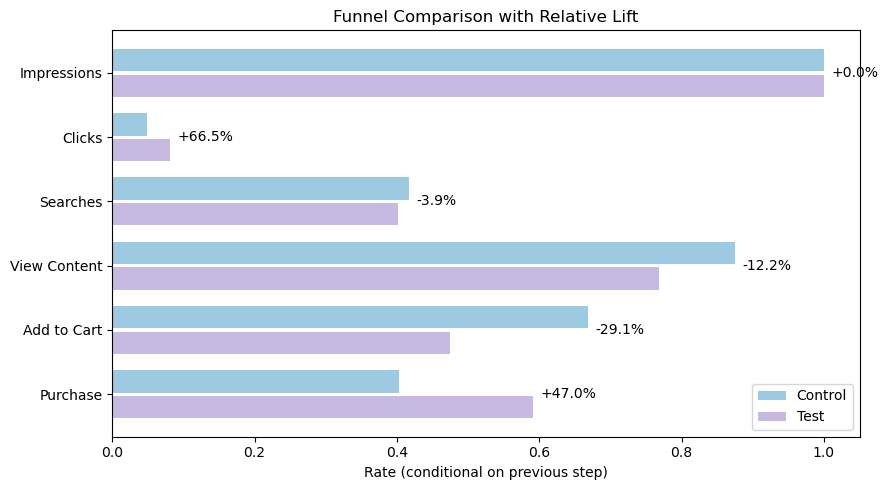

In [113]:
def plot_funnel_with_lift(control_rates, test_rates):
    steps = control_rates.index
    y = np.arange(len(steps))

    lift = (test_rates - control_rates) / control_rates

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(y - 0.2, control_rates, height=0.35, label='Control', color='#9ecae1')
    ax.barh(y + 0.2, test_rates, height=0.35, label='Test', color='#c7b9e2')

    for i, l in enumerate(lift):
        ax.text(max(control_rates[i], test_rates[i]) + 0.01,
                y[i],
                f'{l:+.1%}',
                va='center')

    ax.set_yticks(y)
    ax.set_yticklabels(steps)
    ax.invert_yaxis()
    ax.set_xlabel('Rate (conditional on previous step)')
    ax.set_title('Funnel Comparison with Relative Lift')
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_funnel_with_lift(control_rates, test_rates)

## 5. Results interpretation 
The analysis revealed substantial increase in click-through rates (66.5%) and overall conversion rates (47%) associated with the new campgaign launch. However, mid-funnel engagement metrics (e.g. search rate, view rate, and add-to-cart rate) indicated declined user engagements compared to the original campaign. 

The **Sample Ratio Mismatch (SRM) check** suggested that the traffic allocation between control and new campaign was **not randomized** or stable over the test period.This was evidenced by inconsistent daily impression volumes, lower overall delivery to the test campaign, and noticale impression spikes compared to the control group. 

These patterns potentially suggesting that the test cammpaign may have disproportionally targeted **high-intent or retargeted users**, who had already engaged with the site in the past. Whereas the original campaign was potentially more focused on **new or prospecting users**. Alternatively, these observed effect could be driven by **platform-level optimization** rather than the effect of campaign.  

## 6. Recommendations 
- Investigate the traffic allocation and delivery mechanisms, including: 
   - audiance targeting rules (e.g. high-intent/retargeted users vs new/prospecting users)
   - platform delivery channel (e.g. website vs mobile app) 
   - platform optimization behaviour 
  to see if there is delivery bias during the campaign launch
- Fix the randamization strategy
   - by using a stratified randomization (block by key audience characteristics, e.g. type)
- Rerun the experiment, using either: 
   - a stratified randomization (block by audience type)
   - or, parallel experiments for each audience type
- Strengthen experiment monitoring 
   - by monitoring SRM early in the experiment cycle 
   - by monitoring real-time impression balance, audience composition, and delivery channels 
   - by predefining invalidation criteria if allocation imbalance exceeds acceptable thresholds




## 7. Summary 

In conclusion, the results are likely reflecting the **delivery bias** and **audience composition effects**, and should be interpreted as **associative rather than causal**. A rerun with a **stratified randomization or parallel experiments** for each audience type may help to draw causal conclusions. 